# **Task 1 - POS Tagger Implementation from scratch**

In [1]:
import nltk   
from nltk import word_tokenize
from nltk.corpus import treebank, stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tqdm import tqdm

**Step 1: Load and preprocess the treebank corpus**

In [2]:
# Download and load the treebank corpus, which contains part-of-speech (POS) tagged sentences
nltk.download('treebank')
tagged_sentences = treebank.tagged_sents() # Each sentence is a list of (word, POS tag) tuples
dataset = list(tagged_sentences)
print(len(dataset))

# Dataset visualization: Display the first 5 sentences with their corresponding POS tags
for item in range(5):
    print(len(dataset[item]), dataset[item], sep='\n', end='\n\n')

[nltk_data] Downloading package treebank to /usr/share/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
3914
18
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]

13
[('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')]

27
[('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director

In [3]:
# Split the dataset into training and test sets (test set is very small, just for visualization)

train_set, test_set = train_test_split(dataset, test_size=0.0005, shuffle=False)
print(len(train_set), len(test_set))

3912 2


In [4]:
# Flatten the training data (list of sentences) into a list of (word, POS tag) tuples
train_data = []
for sentence in tagged_sentences:
    train_data.extend(sentence)

In [5]:
# Separate the words and their corresponding tags into two lists
words = []
tags = []
for word, tag in train_data:
    words.append(word)
    tags.append(tag)
    
# Identify the unique words and tags in the dataset
unique_words = list(set(words))
print(len(unique_words), unique_words[:50], sep='\n\n')

unique_tags = list(set(tags))
print(len(unique_tags), unique_tags, sep='\n\n', end='\n\n')

12408

['Gaja', 'promissory', 'IBM', 'transferring', 'administrator', 'Spielvogel', 'fare', 'equals', '*T*-185', 'payments', 'Metal', 'Nasdaq', 'task', 'defuse', 'Patrick', 'release', 'trash', 'game', 'Hoffman', 'exhausted', 'Alliance', 'young', '5.435', 'spurns', 'chicago', 'compressed', 'GAF', 'job', 'Superdome', 'dispute', 'Mitsubishi', 'everywhere', '*T*-80', 'upbeat', 'Fishman', 'Boca', '24.95', 'visiting', '133.7', 'recombinant', 'Close', 'quarter', 'anticipates', 'marketed', 'situation', 'That', 'Marder', 'catch', 'each', 'countries']
46

["''", 'DT', 'NNP', 'CC', 'RBS', 'EX', 'NN', 'MD', 'NNS', 'SYM', 'JJ', 'POS', '#', 'VBN', 'VBP', 'JJS', 'WP', 'JJR', 'RB', ',', 'UH', 'VB', '-RRB-', 'VBG', 'CD', '-LRB-', 'VBZ', 'WDT', 'PRP', '.', 'RBR', 'LS', '-NONE-', 'RP', 'FW', 'VBD', 'NNPS', 'WRB', '$', 'PRP$', 'PDT', 'WP$', '``', 'IN', 'TO', ':']



 **Step 2: Calculate Transition and Emission Probabilities**

In [6]:
# Compute the transition probability P(tag_2 | tag_1) which is the probability of tag_2 following tag_1
def transition_probability_calculator(tag_2, tag_1):
    count_tag_1 = 0
    for tag in tags:
        if tag == tag_1:
            count_tag_1 += 1
    
    count_tag_2_given_tag1 = 0
    for index in range(len(tags) - 1):
        if tags[index] == tag_1 and tags[index + 1] == tag_2:
            count_tag_2_given_tag1 += 1
    return count_tag_2_given_tag1/count_tag_1

In [7]:
# Creating a tag_1 x tag_2 transition matrix
# Each column is tag_2 and each row is tag_1
# Thus tags_matrix(i, j) represents P(tag_j|tag_i)

tags_probability_matrix = np.zeros((len(unique_tags), len(unique_tags)), dtype='float32')
for index_1, tag_1 in enumerate(unique_tags):
    for index_2, tag_2 in enumerate(unique_tags):
        tags_probability_matrix[index_1, index_2] = transition_probability_calculator(tag_2, tag_1)

# Convert the matrix to a data frame for better readability
tags_probability_data_frame = pd.DataFrame(
    tags_probability_matrix,
    columns=unique_tags,
    index=unique_tags
)

In [8]:
# Flatten the entire dataset (train and test) into a list of (word, POS tag) tuples
train_tagged_words = []
for tagged_sentence in dataset:
    for tagged_word in tagged_sentence:
        train_tagged_words.append(tagged_word)

In [9]:
# Compute the emission probability P(word | tag) which is the probability of a word given a POS tag
def emission_probability_calculator(word, tag):
    tag_list = []
    for tagged_word in train_tagged_words:
        if tagged_word[1] == tag:
            tag_list.append(tagged_word)
    
    word_given_tag_list = []
    for tagged_word in tag_list:
        if tagged_word[0] == word:
            word_given_tag_list.append(tagged_word)
    return len(word_given_tag_list)/len(tag_list)

In [10]:
# Create a dictionary where each word maps to a list of possible tags it has in the training data
tag_list_for_unique_words = {}
for word in tqdm(unique_words):
    temporary_set = set()
    for tagged_word in train_tagged_words:
        if word == tagged_word[0]:
            temporary_set.add(tagged_word[1])
    tag_list_for_unique_words[word] = list(temporary_set)
    
# for word in tag_list_for_unique_words:
#     print(word, tag_list_for_unique_words[word])

100%|██████████| 12408/12408 [02:28<00:00, 83.31it/s]


 **Viterbi Algorithm**

In [11]:
# Viterbi algorithm implementation for POS tagging, considering smoothing for unseen words/tags
def viterbi(words):
    state = []
    previous_probability = {}
    updated_probability = {}
    for tag in unique_tags:
        previous_probability[tag] = 1.0 / len(unique_tags)
        
    for index, word in enumerate(words):
        for tag in unique_tags:
            updated_probability[tag] = 0
        state_max = '-NONE-'
        # Handle if the current word is present in training corpora
        if word in tag_list_for_unique_words:
            max_probability = 0.
            for tag in tag_list_for_unique_words[word]:
                transition_probability = 0.
                if index == 0:
                    # Assuming that their is a punctuation mark before a starting of a sentence
                    # Base case for the starting tag at the start of the sentence
                    transition_probability = tags_probability_data_frame.loc['.', tag]
                else:
                    # Compute transition probabilities from all previous state's tags as it is a bigram model
                    # As we are considering all tags in previous state, iterate
                    # and take max over them and update transition probability
                    
                    # Handle if previous word present in trainging corpora
                    if words[index-1] in tag_list_for_unique_words:
                        for tag_previous in tag_list_for_unique_words[words[index-1]]:
                            transition_probability = max(
                                transition_probability,
                                previous_probability[tag_previous] * tags_probability_data_frame.loc[tag_previous, tag]
                            )
                    # Handle if previous word not present in trainging corpora
                    else:
                        # Taking the probability of choosing only one transition out of all possibilities of previous state
                        for tag_previous in unique_tags:
                            transition_probability = max(
                                transition_probability,
                                previous_probability[tag_previous] * tags_probability_data_frame.loc[tag_previous, tag]
                            )
                
                emission_probability = emission_probability_calculator(word, tag)
                total_probability = emission_probability * transition_probability
                
                # AS we had already multiplied previous probability with transition probability, we can dirctly update the value in new array
                updated_probability[tag] = total_probability

                if max_probability < total_probability:
                    max_probability = total_probability
                    state_max = tag

            state.append(state_max)
        # Handle if the current word is not present in training corpora
        elif index > 0 and words[index-1] in tag_list_for_unique_words:
            # Emission is not possible here
            max_probability = 0.
            for tag in unique_tags:
                transition_probability = 0.
                for tag_previous in tag_list_for_unique_words[words[index-1]]:
                    calculated_probability = previous_probability[tag_previous] * tags_probability_data_frame.loc[tag_previous, tag]
                    if transition_probability < calculated_probability:
                        transition_probability = calculated_probability
                if max_probability < transition_probability:
                    max_probability = transition_probability
                    state_max = tag
                
                updated_probability[tag] = transition_probability
            state.append(state_max)
        else:
            # If neither of the two words are present in corpus, assign NONE and assign previous probability to updated one
            for tag in unique_tags:
                updated_probability[tag] = previous_probability[tag]
            state.append(state_max)
            
        # Update previous probability
        for tag in unique_tags:
            previous_probability[tag] = updated_probability[tag]
            
    return list(zip(words, state))

In [12]:
# Prepare the test set for evaluating POS tagging given by viterbi
test_run_base = [tup for sent in test_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

# Run Viterbi algorithm on the test set and evaluate accuracy
tagged_seq = viterbi(test_tagged_words)
correct_detction = 0
for predicted, actual in zip(tagged_seq, test_run_base):
    if (predicted==actual):
        correct_detction += 1

accuracy = correct_detction / len(tagged_seq)
print(accuracy) # Print accuracy of the POS tagger on the test set

1.0


# **TASK 2 : Vanilla Emotion Recognizer**

**Step 1 :  Load and preprocess the twitter_messages corpus**

In [13]:
# Load the emotion dataset from Hugging Face
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion","split")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

In [15]:
# Function to preprocess data and extract texts and labels
def preprocess_data(data):
    texts = [item["text"] for item in data]
    labels = [item["label"] for item in data]  # Assuming 'label' is the key for emotions
    return texts, labels

# Preprocess the datasets
train_texts, train_labels = preprocess_data(train_data)
validation_texts, validation_labels = preprocess_data(validation_data)
test_texts, test_labels = preprocess_data(test_data)

**Step 2 : Sentence embeddings**

In [16]:
# Convert texts into TF-IDF feature vectors
vectorizer = TfidfVectorizer()
train_embeddings = vectorizer.fit_transform(train_texts)
validation_embeddings = vectorizer.transform(validation_texts)
test_embeddings = vectorizer.transform(test_texts)

**Step 3 : Naive Bayes and SVM for emotion recognition**

In [17]:
# Naive Bayes with Randomized Search for Hyperparameter Tuning
def create_naive_bayes_model():
    return MultinomialNB()

def train_naive_bayes_with_random_search(train_embeddings, train_labels):
    param_dist = {
        'alpha': np.linspace(0.1, 2.0, 10)
    }
    nb_model = MultinomialNB()
    random_search = RandomizedSearchCV(nb_model, param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
    random_search.fit(train_embeddings, train_labels)
    best_model = random_search.best_estimator_
    print("Best Hyperparameters for Naive Bayes:", random_search.best_params_)
    return best_model

# SVM with Randomized Search for Hyperparameter Tuning
def create_svm_model():
    return SVC(kernel='linear', class_weight='balanced')

def train_svm_with_random_search(train_embeddings, train_labels):
    param_dist = {
        'C': np.logspace(-2, 2, 5),
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    svm_model = SVC()
    random_search = RandomizedSearchCV(svm_model, param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
    random_search.fit(train_embeddings, train_labels)
    best_model = random_search.best_estimator_
    print("Best Hyperparameters for SVM:", random_search.best_params_)
    return best_model

def evaluate_model(model, embeddings, labels, data_split_name=""):
    preds = model.predict(embeddings)
    accuracy = accuracy_score(labels, preds)
    report = classification_report(labels, preds, zero_division=1)
    print(f"{data_split_name} Accuracy:", accuracy)
    print(f"{data_split_name} Classification Report:\n", report)
    return preds

def plot_confusion_matrix(model, true_labels, predicted_labels, title='Confusion Matrix'):
    cm = confusion_matrix(true_labels, predicted_labels, labels=model.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

Best Hyperparameters for Naive Bayes: {'alpha': 0.1}
Validation Accuracy: 0.7525
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79       550
           1       0.74      0.93      0.82       704
           2       0.94      0.28      0.43       178
           3       0.87      0.60      0.71       275
           4       0.85      0.54      0.66       212
           5       1.00      0.17      0.29        81

    accuracy                           0.75      2000
   macro avg       0.85      0.57      0.62      2000
weighted avg       0.79      0.75      0.73      2000

Test Accuracy: 0.7435
Test Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.89      0.79       581
           1       0.72      0.95      0.82       695
           2       0.88      0.31      0.46       159
           3       0.87      0.53      0.66       275
           4       

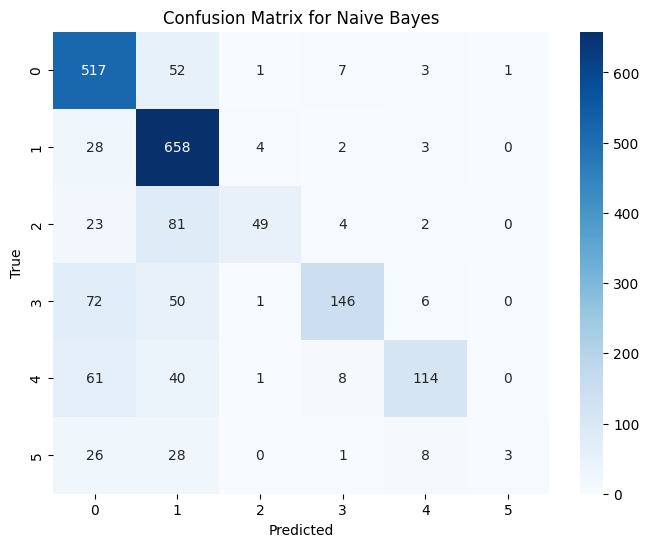

In [18]:
# Naive Bayes for vanilla emotion recognition
nb_model = train_naive_bayes_with_random_search(train_embeddings, train_labels)
validation_preds_nb = evaluate_model(nb_model, validation_embeddings, validation_labels, "Validation")
test_preds_nb = evaluate_model(nb_model, test_embeddings, test_labels, "Test")
plot_confusion_matrix(nb_model, test_labels, test_preds_nb, "Confusion Matrix for Naive Bayes")

Best Hyperparameters for SVM: {'kernel': 'linear', 'class_weight': 'balanced', 'C': 1.0}
Validation Accuracy: 0.885
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       550
           1       0.95      0.87      0.91       704
           2       0.75      0.96      0.84       178
           3       0.86      0.90      0.88       275
           4       0.81      0.84      0.82       212
           5       0.77      0.90      0.83        81

    accuracy                           0.89      2000
   macro avg       0.84      0.89      0.87      2000
weighted avg       0.89      0.89      0.89      2000

Test Accuracy: 0.8815
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       581
           1       0.95      0.87      0.91       695
           2       0.67      0.93      0.78       159
           3       0.86      0.90     

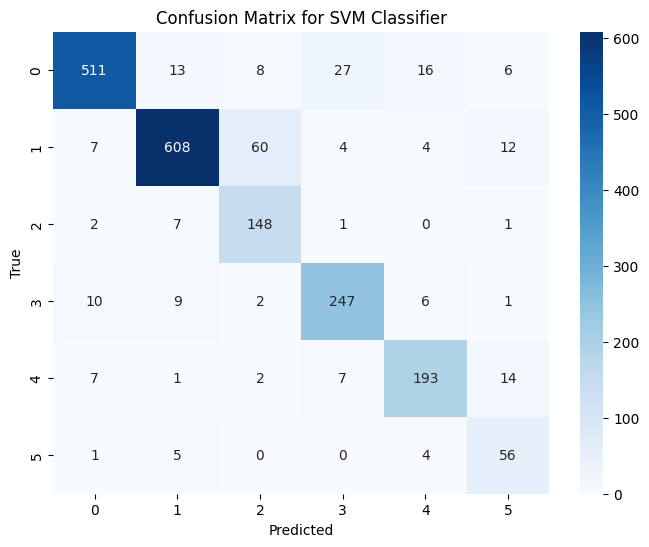

In [19]:
# SVM for vanilla emotion recognition
svm_model = train_svm_with_random_search(train_embeddings, train_labels)
validation_preds_svm = evaluate_model(svm_model, validation_embeddings, validation_labels, "Validation")
test_preds_svm = evaluate_model(svm_model, test_embeddings, test_labels, "Test")
plot_confusion_matrix(svm_model, test_labels, test_preds_svm, "Confusion Matrix for SVM Classifier")

# **Task 3 : Enhanced Emotion Recognizer Incorporating POS tags in pipeline**

In [20]:
# Downloading the WordNet corpus and extracting it (in case it's needed for lemmatization)
nltk.download('wordnet')
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [21]:
# Initialize a lemmatizer from the WordNet corpus and load the stop words list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [22]:
# Function to POS tag sentences using the custom Viterbi POS tagger
def pos_tag_sentences(sentences):
    pos_tagged_sentences = [] # List to store POS-tagged sentences
    
    # Iterate over each sentence and apply POS tagging
    for sentence in tqdm(sentences, desc="POS Tagging Progress"):
        # Tokenize the sentence into words
        tokens = word_tokenize(sentence)
        
        # Lemmatize the tokens and remove stop words
        lemmatized_token = []
        for token in tokens:
            if token not in stop_words:
                lemmatized_token.append(lemmatizer.lemmatize(token))
        
        # Apply the Viterbi algorithm to get the POS tags for each word
        vitebri_output = viterbi(lemmatized_token)
        
        # Prepare the sentence with POS tags in the format "word:<POS>"
        vitebri_token = []
        for item in vitebri_output:
            vitebri_token.append(item[0] + ":<" + item[1] + ">")
            
        # Join the words back into a string and add it to the list
        tokenized_string = " ".join(vitebri_token)
        pos_tagged_sentences.append(tokenized_string)
    return pos_tagged_sentences

# POS tag the train, validation, and test sets
train_pos_tags = pos_tag_sentences(train_texts)
validation_pos_tags = pos_tag_sentences(validation_texts)
test_pos_tags = pos_tag_sentences(test_texts)

POS Tagging Progress: 100%|██████████| 2000/2000 [03:46<00:00,  8.82it/s]


In [23]:
# Convert POS-tagged sentences into TF-IDF feature vectors
vectorizer = TfidfVectorizer()
train_pos_embeddings = vectorizer.fit_transform(train_pos_tags)
validation_pos_embeddings = vectorizer.transform(validation_pos_tags)
test_pos_embeddings = vectorizer.transform(test_pos_tags)

Best Hyperparameters for Naive Bayes: {'alpha': 0.1}
Validation Accuracy: 0.7605
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.92      0.81       550
           1       0.74      0.93      0.82       704
           2       0.92      0.32      0.47       178
           3       0.89      0.62      0.73       275
           4       0.83      0.56      0.67       212
           5       0.94      0.20      0.33        81

    accuracy                           0.76      2000
   macro avg       0.84      0.59      0.64      2000
weighted avg       0.79      0.76      0.74      2000

Test Accuracy: 0.7555
Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.81       581
           1       0.72      0.95      0.82       695
           2       0.88      0.32      0.47       159
           3       0.87      0.57      0.69       275
           4       

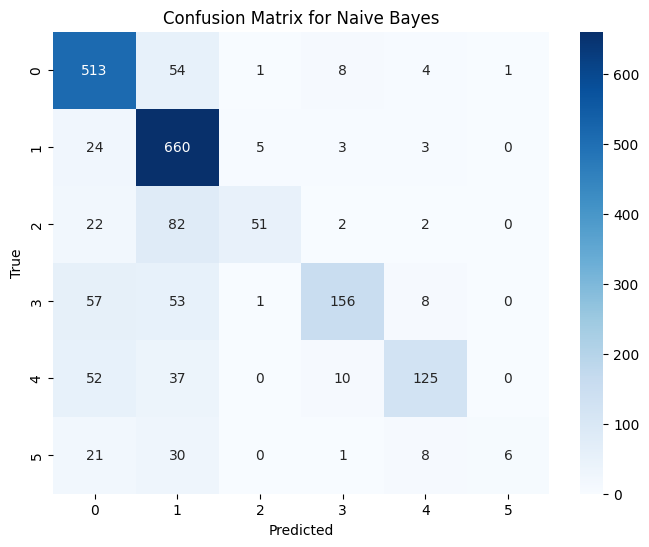

In [24]:
# Naive Bayes for Enhanced Emotion Recognizer Incorporating POS tags in pipeline
nb_model = train_naive_bayes_with_random_search(train_pos_embeddings, train_labels)
validation_preds_nb = evaluate_model(nb_model, validation_pos_embeddings, validation_labels, "Validation")
test_preds_nb = evaluate_model(nb_model, test_pos_embeddings, test_labels, "Test")
plot_confusion_matrix(nb_model, test_labels, test_preds_nb, "Confusion Matrix for Naive Bayes")

Best Hyperparameters for SVM: {'kernel': 'linear', 'class_weight': 'balanced', 'C': 1.0}
Validation Accuracy: 0.887
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92       550
           1       0.96      0.87      0.91       704
           2       0.74      0.96      0.83       178
           3       0.87      0.90      0.88       275
           4       0.80      0.85      0.82       212
           5       0.73      0.88      0.80        81

    accuracy                           0.89      2000
   macro avg       0.84      0.89      0.86      2000
weighted avg       0.90      0.89      0.89      2000

Test Accuracy: 0.88
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92       581
           1       0.95      0.87      0.91       695
           2       0.67      0.94      0.78       159
           3       0.85      0.90      0

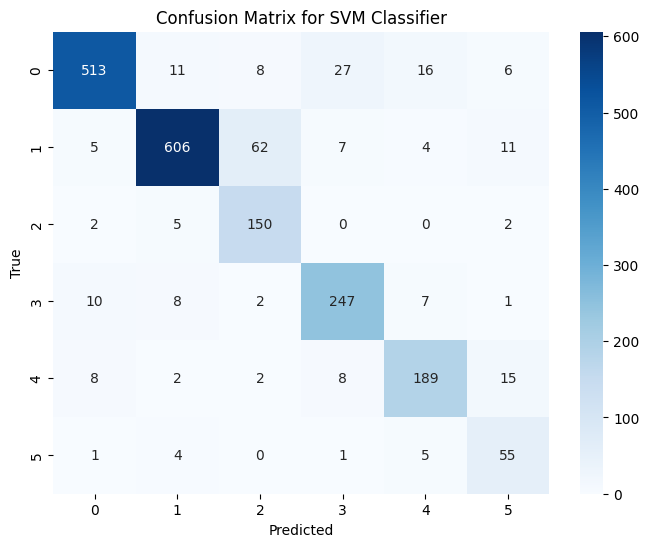

In [25]:
# SVM for Enhanced Emotion Recognizer Incorporating POS tags in pipeline
svm_model = train_svm_with_random_search(train_pos_embeddings, train_labels)
validation_preds_svm = evaluate_model(svm_model, validation_pos_embeddings, validation_labels, "Validation")
test_preds_svm = evaluate_model(svm_model, test_pos_embeddings, test_labels, "Test")
plot_confusion_matrix(svm_model, test_labels, test_preds_svm, "Confusion Matrix for SVM Classifier")